## Deep-Coin
the trading agent
### Baseline architecture with 1D Convolutional network using keras API and Tensorflow backend

In [24]:
from __future__ import print_function, division
import gc
import sys
import os
import math
from matplotlib import style
import matplotlib.dates as mdates
import datetime as dt

import numpy as np
import pandas as pd
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from keras.models import Sequential

import matplotlib.pyplot as plt

%matplotlib inline
style.use ('ggplot')

### Data prepration

In [25]:
data_file = '~/data/bitstampUSD_1-min_data_2012-01-01_to_2017-05-31.csv'
df = pd.read_csv(data_file, parse_dates=True, keep_date_col=True, index_col=0, infer_datetime_format=True, error_bad_lines=False)
df = df.dropna()
df = df.drop(['Open', 'High', 'Low', 'Volume_(Currency)', 'Weighted_Price'], axis=1)
df.index = pd.to_datetime(df.index, utc=True, unit='s')
print(len(df))
df.head()

1650904


,Close,Volume_(BTC)
Timestamp,,
2011-12-31 07:52:00+00:00,4.39,0.455581
2011-12-31 15:50:00+00:00,4.39,48.000000
2011-12-31 16:59:00+00:00,4.57,37.862297
2011-12-31 17:00:00+00:00,4.58,9.000000
2012-01-01 04:16:00+00:00,4.58,1.502000


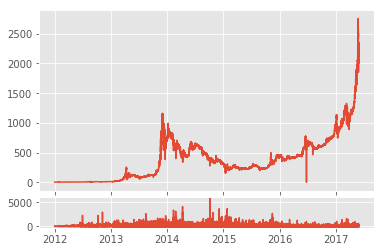

In [26]:
ax1 = plt.subplot2grid((6, 1), (0, 0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((6, 1), (5, 0), rowspan=1, colspan=1, sharex=ax1)

ax1.plot(df.index, df['Close'])
ax2.plot(df.index, df['Volume_(BTC)'])

plt.show()

In [32]:
training_size = 1000000
validation_size = 500000
test_size = 150904
train_df = df[:training_size]
valid_df = df[training_size:training_size+validation_size]
test_df = df[training_size+validation_size:]
print(len(train_df), len(valid_df), len(test_df))

1000000 500000 150904


## build_convolution1D_model():
returns a Keras model for predicting the next value in a timeseries given a fixed-size lookback window of previous values.
The model can handle multiple input timeseries (`nb_input_series`) and multiple prediction targets (`nb_outputs`).

## Parameters:
#### window_size: 
The number of previous timeseries values to use as input features.  Also called lag or lookback.

#### nb_input_series: 
The number of input timeseries; 1 for a single timeseries.
The `X` input to ``fit()`` should be an array of shape ``(n_instances, window_size, nb_input_series)``; each instance is a 2D array of shape ``(window_size, nb_input_series)``. For example, for `window_size` = 3 and `nb_input_series` = 1 (a single timeseries), one instance could be ``[[0], [1], [2]]``. See ``make_timeseries_instances()``.

#### nb_outputs: 
The output dimension, often equal to the number of inputs. For each input instance (array with shape ``(window_size, nb_input_series)``), the output is a vector of size `nb_outputs`, usually the value(s) predicted to come after the last value in that input instance, i.e., the next value in the sequence. The `y` input to ``fit()`` should be an array of shape ``(n_instances, nb_outputs)``.

#### filter_length: 
the size (along the `window_size` dimension) of the sliding window that gets convolved with each position along each instance. The difference between 1D and 2D convolution is that a 1D filter's "height" is fixed
      to the number of input timeseries (its "width" being `filter_length`), and it can only slide along the window dimension. This is useful as generally the input timeseries have no spatial/ordinal relationship, so it's not meaningful to look for patterns that are invariant with respect to subsets of the timeseries.

#### nb_filters: 
The number of different filters to learn (roughly, input patterns to recognize).

In [20]:
def build_convolution1D_model(window_size, filter_length, nb_input_series=1, nb_outputs=1, nb_filter=4):
    
    model = Sequential((
        # The first conv layer learns `nb_filter` filters (aka kernels), each of size ``(filter_length, nb_input_series)``.
        # Its output will have shape (None, window_size - filter_length + 1, nb_filter), i.e., for each position in
        # the input timeseries, the activation of each filter at that position.
        
        Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu', input_shape=(window_size, nb_input_series)),
        MaxPooling1D(), # Downsample the output of convolution by 2X.
        Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu'),
        MaxPooling1D(),
        Flatten(),
        Dense(nb_outputs, activation='linear'), # For binary classification, change the activation to 'sigmoid'
    ))
    
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    # To perform (binary) classification instead:
    # model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
    
    return model

In [34]:
window_size = 60
nb_filter = 4
filter_length = 5
nb_input_series = 2
nb_outputs = 2

In [35]:
model = make_timeseries_regressor(window_size=window_size, filter_length=filter_length, nb_input_series=nb_input_series, nb_outputs=nb_outputs, nb_filter=nb_filter)
print('\n\nModel with input size {}, output size {}, {} conv filters of length {}'.format(model.input_shape, model.output_shape, nb_filter, filter_length))
model.summary()



Model with input size (None, 60, 2), output size (None, 2), 4 conv filters of length 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 56, 4)             44        
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 28, 4)             0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 24, 4)             84        
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 12, 4)             0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 48)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 98        
Total params: 226
Trainable params: 226
Non-trainable